<a href="https://colab.research.google.com/github/Two-Silver/AI-vs-Human/blob/main/AI_vs_Human.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 로드



In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/A.ing/AI vs. Human/AI_Human.csv')
print(df.shape)
df.head()

(487235, 2)


,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


## Del 데이터

In [ ]:
from sklearn.model_selection import train_test_split

# 전체 데이터 중 0.005%만 사용
df2, df = train_test_split(df, test_size=0.005, random_state=42)
del df2

In [ ]:
print(df.shape)
print(df['generated'].value_counts()[0])
print(df['generated'].value_counts()[1])

(2437, 2)
1507
930


# Train Data / Validation Data

In [ ]:
from sklearn.model_selection import train_test_split

# train data와 validation data 나눔.
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)  # validataion data 0.2% 사용

print("Training set size:", len(train_df))
print("Validation set size:", len(valid_df))

Training set size: 1949
Validation set size: 488


# Text 전처리

텍스트 데이터를 숫자 시퀀스로 변환하여 입력 데이터로 사용하는 과정.

In [ ]:
from collections import Counter
from keras.preprocessing.sequence import pad_sequences

# 단어 빈도수 계산 및 단어 사전 생성
word_count = Counter()
for text in train_df['text']:
    for word in text.split():
        word_count[word] += 1

# 단어 사전 생성 (단어를 인덱스 매핑)
vocabulary = {word: i+1 for i, word in enumerate(word_count)}  # start indexing from 1
vocab_size = len(vocabulary) + 1  # plus one for padding

# 토큰화
def tokenize(texts, vocab, max_length):
    sequences = [[vocab[word] for word in text.split() if word in vocab] for text in texts]
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences

# train/validatain text 데이터 토큰화
max_length = 100  # Adjust based on your dataset
X_train = tokenize(train_df['text'], vocabulary, max_length)
X_valid = tokenize(valid_df['text'], vocabulary, max_length)


# DataSet 정의

In [ ]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_dataset = TextDataset(X_train, train_df['generated'].values)
valid_dataset = TextDataset(X_valid, valid_df['generated'].values)

# DataLoader 생성

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 64,
    shuffle = True,
    drop_last = True
)

valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = 16,
    shuffle = False,
    drop_last = True
)

# 모델 정의



In [ ]:
import torch.nn as nn

# model = TextClassifier(vocab_size=vocab_size, embedding_dim=100, hidden_dim=128, output_dim=1)
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)   # 임베딩 벡터로 변환
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text).mean(dim=1)  # Mean across the sequence length
        hidden = self.relu(self.fc1(embedded))
        output = self.fc2(hidden)
        return self.sigmoid(output)



In [ ]:
text, label = next(iter(train_loader))
model = TextClassifier(vocab_size=vocab_size, embedding_dim=100, hidden_dim=128, output_dim=1)
print(f'{text.shape=}')
tmp = model(text)
print(f'{tmp.shape=}')

text.shape=torch.Size([64, 100])
tmp.shape=torch.Size([64, 1])


In [ ]:
# 모델의 각 계층의 이름과 해당 계층의 파라미터 출력
for params in model.named_parameters():
    print(params)

('embedding.weight', Parameter containing:
tensor([[-2.0862,  1.4601,  0.4903,  ..., -0.5283, -1.7138, -0.1721],
        [-1.5968, -1.0660, -0.6163,  ...,  0.0851, -2.1305,  0.7106],
        [-1.3472, -0.0711,  0.7627,  ..., -0.2059,  1.4581, -0.1643],
        ...,
        [ 0.1233, -0.7018,  0.0596,  ...,  1.6154, -0.0937,  0.9960],
        [-0.5179, -0.2898,  1.8942,  ...,  1.3555, -1.0270,  1.2828],
        [ 1.0428, -0.6278, -0.1279,  ..., -1.2330, -1.3371,  0.3977]],
       requires_grad=True))
('fc1.weight', Parameter containing:
tensor([[-0.0667, -0.0563,  0.0633,  ..., -0.0252, -0.0110,  0.0584],
        [ 0.0412, -0.0687,  0.0051,  ..., -0.0148, -0.0831,  0.0240],
        [ 0.0679, -0.0186, -0.0948,  ...,  0.0132,  0.0067,  0.0073],
        ...,
        [ 0.0167,  0.0981,  0.0059,  ..., -0.0960,  0.0038, -0.0827],
        [ 0.0665,  0.0469, -0.0692,  ...,  0.0502, -0.0681,  0.0275],
        [ 0.0552, -0.0148,  0.0821,  ..., -0.0475,  0.0309,  0.0164]],
       requires_grad=Tru

# Train 정의

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

def train_loop(model, iterator, valid, optimizer, criterion, num_epochs):
    model.train()
    log_hist = torch.zeros([0,3])

    # 에폭 수에 대해 반복
    for epoch in range(1, num_epochs+1):
        print(f'\r {epoch}',end='')

        # 각 배치에 대해 반복
        for texts, labels in iterator:
            predictions = model(texts).squeeze(1)   # 예측값 계산
            loss = criterion(predictions, labels)   # 손실 계산

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # validation set에 대한 손실 계산
        with torch.no_grad():
            for texts, labels in valid:
                pred = model(texts).squeeze(1)

                # validation loss
                e_loss = criterion(pred, labels)


        tmp = torch.tensor([epoch, loss.item(), e_loss.item()])
        log_hist = torch.concat((log_hist, tmp.reshape(1,-1)), dim=0)
        print(f' Epoch / loss {loss.item():.4f} / val_loss {e_loss.item():.4f}')

        # if epoch % 100 == 0 or epoch == 1:
        #     tmp = torch.tensor([epoch, loss.item(), e_loss.item()]).to(log_hist.device)
        #     log_hist = torch.concat( (log_hist, tmp.reshape(1,-1)), dim=0 )
        #     print(f' Epoch / loss {loss.item():.4f} / val_loss {e_loss.item():.4f}')

        # if epoch == num_epochs:
        #     print(f' Epoch / loss {loss.item():.4f} / val_loss {e_loss.item():.4f}')


    return model, log_hist

# Result

In [ ]:
# Training loop
num_epochs = 50  # 에폭 수
final_model, log_hist = train_loop(model, train_loader, valid_loader, optimizer, criterion, num_epochs)

 1 Epoch / loss 0.6445 / val_loss 0.6566
 2 Epoch / loss 0.5246 / val_loss 0.5548
 3 Epoch / loss 0.3507 / val_loss 0.4277
 4 Epoch / loss 0.2350 / val_loss 0.3098
 5 Epoch / loss 0.2014 / val_loss 0.2014
 6 Epoch / loss 0.1911 / val_loss 0.1505
 7 Epoch / loss 0.0950 / val_loss 0.1233
 8 Epoch / loss 0.0830 / val_loss 0.1071
 9 Epoch / loss 0.0702 / val_loss 0.0976
 10 Epoch / loss 0.0798 / val_loss 0.0945
 11 Epoch / loss 0.0443 / val_loss 0.0900
 12 Epoch / loss 0.0127 / val_loss 0.0926
 13 Epoch / loss 0.0063 / val_loss 0.0814
 14 Epoch / loss 0.0072 / val_loss 0.0828
 15 Epoch / loss 0.0328 / val_loss 0.0795
 16 Epoch / loss 0.0034 / val_loss 0.0752
 17 Epoch / loss 0.0034 / val_loss 0.0753
 18 Epoch / loss 0.0043 / val_loss 0.0708
 19 Epoch / loss 0.0034 / val_loss 0.0685
 20 Epoch / loss 0.0012 / val_loss 0.0688
 21 Epoch / loss 0.0021 / val_loss 0.0661
 22 Epoch / loss 0.0026 / val_loss 0.0639
 23 Epoch / loss 0.0026 / val_loss 0.0636
 24 Epoch / loss 0.0015 / val_loss 0.0621
 

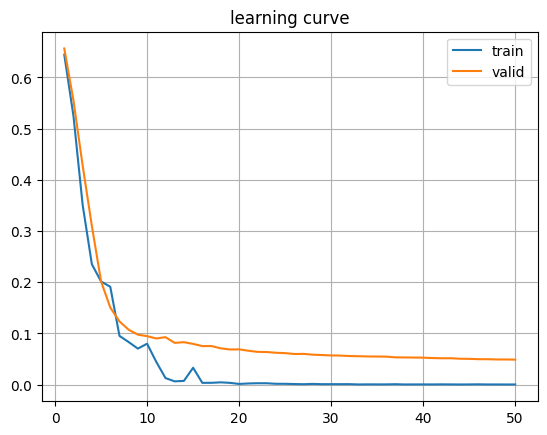

In [ ]:
# Visualization
import matplotlib.pyplot as plt

start = 0

fig, axes = plt.subplots(1,1)
axes.set_title('learning curve')
axes.plot(log_hist.detach()[start:,0], log_hist[start:,1], label='train')
axes.plot(log_hist.detach()[start:,0], log_hist[start:,2], label='valid')
axes.legend()
axes.grid()
fig.show()